In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def func(x):
    return np.tan(0.49*np.pi*np.cos(1/(1.1 + np.sin(x**2))))

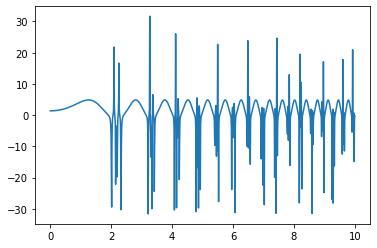

In [8]:
xs = np.linspace(0,10,1000)
plt.plot(xs, func(xs))

In [32]:
from queue import Queue
import multiprocessing as mp
import time

class Integrator:
    def __init__(self, workers=None, initial_step=10**(-3), minimal_step=10**(-5), step_prec=10**(-6)):
        self.task_q = Queue()
        self.pool = mp.Pool(processes=workers)

        self.initial_step = initial_step
        self.minimal_step = minimal_step
        self.step_prec = step_prec
    
    def step_is_big(self, f, x, h):
        return abs(f(x) - f(x+h))*h > self.step_prec

    def worker_thread(self, f, start, stop):
        print(start, stop)
        x = start
        h = self.initial_step
        accumulator = 0
        while x < stop:
            if x + h > stop:
                h = stop - x
            
            if self.step_is_big(f, x, h):
                h = min(h/2, self.minimal_step)
            else:
                accumulator += h*f(x)
                x += h
        
        return accumulator

    def integrate(self, f, a, b):
        if b < a:
            a,b = b,a

        N = 100
        async_res = []
        for i in range(1, N+1):
            d = (b-a)/N
            async_res.append(self.pool.apply_async(self.worker_thread, f, (i-1)*d, i*d))
        
        result = 0
        for obj in async_res:
            obj.wait()
            print(obj.get())
        return result
        

integ = Integrator()
integ.integrate(func, 0, 10)

TypeError: cannot pickle '_thread.lock' object